<h1 align="center"> Diabetic Retinopathy Detection</h1><hr>

## Overview
<h3> Objective:</h3>
Help people to diagnose diabetic retinopathy and test/improve my deep learning skills.
<br><br>
<h3>What is diabetic retinopathy?</h3>
Diabetic retinopathy is the most common diabetic eye disease and can cause severe vision loss or even blindness. It is caused by changes in the blood vessels of the retina like swell and leak fluid or blood, in other people with diabetes, abnormal new blood vessels grow on the surface of the retina.
<br>
According to [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4657234/), of an estimated 285 million people with diabetes mellitus worldwide, approximately one third have signs of DR and of these, a further one third of DR is vision-threatening DR, including diabetic macular edema (DME).
<br>
<br>
<hr>
<h3>How our dataset looks like?</h3>
We are provided with almost 82GB of data, it includes images of left or right eye with a suspicious DR and a training labels csv that link our image name with an id at the csv and show what is the true situation of the eye.<br>
The csv file are scaled of 0 to 4 on each image with the following situation for each value:<br><br>
0 - No DR<br>
1 - Mild<br>
2 - Moderate<br>
3 - Severe<br>
4 - Proliferative DR<br>
<hr>
Now let's see our images and our csv file!

## Checking our data

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # show figures
import seaborn as sns # show figures
import os # dir
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/lib/kaggle/gcp.py
/kaggle/lib/kaggle/competitions/twosigmanews/__init__.py
/kaggle/lib/kaggle/competitions/twosigmanews/env.py
/kaggle/input/diabetic-retinopathy-detection/169_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/46_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/72_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/356_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/172_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/51_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/513_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/910_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/793_right.jpeg
/kaggle/input/diabetic-retinopathy-detection/162_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/1011_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/650_right.jpeg
/kaggle/input/diabetic-retinopathy-detection/1042_left.jpeg
/kaggle/input/diabetic-retinopathy-detection/1199_left.jpeg
/kaggle/input/diabetic-retinopathy-de

In [0]:
df=pd.read_csv('/kaggle/input/diabetic-retinopathy-detection/trainLabels.csv',sep=',')
df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [0]:
dir_images='/kaggle/input/diabetic-retinopathy-detection/'
df['path']=df['image'].map(lambda x:dir_images+str(x)+'.jpeg')
df['exists']=df['path'].map(os.path.exists)
df.dropna(inplace=True)
df=df[df['exists']]
df.drop(['exists'],inplace=True,axis=1)
df.head()

,image,level,path
0,10_left,0,/kaggle/input/diabetic-retinopathy-detection/1...
1,10_right,0,/kaggle/input/diabetic-retinopathy-detection/1...
2,13_left,0,/kaggle/input/diabetic-retinopathy-detection/1...
3,13_right,0,/kaggle/input/diabetic-retinopathy-detection/1...
4,15_left,1,/kaggle/input/diabetic-retinopathy-detection/1...


Now that we know how many of the csv really have a image we can check the distribution of level.

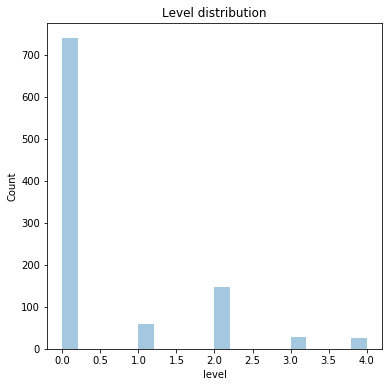

In [0]:
plt.figure(figsize=(6,6))
sns.distplot(df['level'],kde=False)
plt.title('Level distribution')
plt.ylabel('Count')
plt.show()

As we can see we have a lot of No DR, it's very clearly that we have an imbalanced data but we will deal with this later on with over-sampling.<br>

Pacient_Eye: 792_left
Level: 0


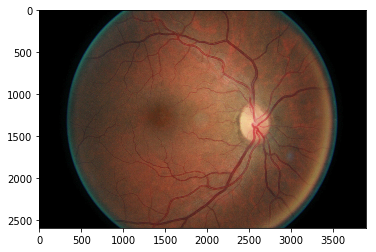

Pacient_Eye: 320_left
Level: 1


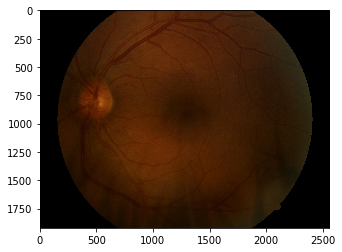

Pacient_Eye: 172_left
Level: 2


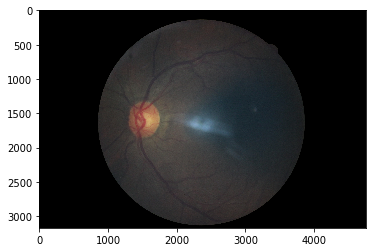

Pacient_Eye: 163_left
Level: 3


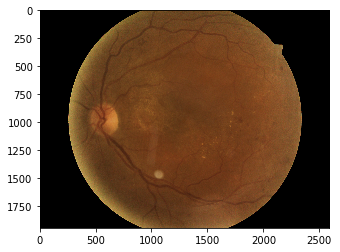

Pacient_Eye: 670_left
Level: 4


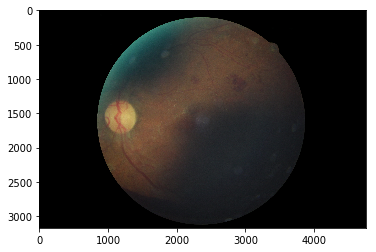

In [0]:
# Getting a sample for each level
for i in range(5):
    eg=df[df['level']==i].sample(1)
    print('Pacient_Eye: '+str(eg.iloc[0][0]))
    print('Level: '+str(eg.iloc[0][1]))
    img=plt.imread(f'{eg.iloc[0][2]}')
    plt.imshow(img)
    plt.show()

<br>
<hr>
<br>
<br>
Note: I've been thinking use data augmentation with noise at the images, but since we have important parts of the image that will help our model identify what's the probability of having a DR, i'll just resize the images so we can improve our accuracy.<br>
<br>
<hr>
<h2>Resizing the images</h2>

Reading this article [Deep Learning Fundus Image Analysis for Diabetic Retinopathy and Macular Edema Grading](https://www.nature.com/articles/s41598-019-47181-w), people who already done they research about DR got better results at validation set with 256x256, so let's give it a try.

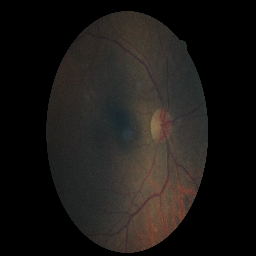

In [0]:
from PIL import Image

# Saving every resized img into a matrix
img_matrix=[]
for i in range(len(df)):
    img=Image.open(df.iloc[i,2])
    img_resized=np.array(img.resize((256,256)))
    img_matrix.append(img_resized)

# Sample of resized
img=Image.fromarray(img_matrix[1],'RGB')
img

Now that we have a better data to use in our neural network, let's create our neural network.

<br>
<hr>
<h2> Neural Network</h2>
This time we will be using something called Transfer Learning.<br>
Transfer learning is the technique to use some neural network or any ML algorithm that was used to solve a similar problem before.<br>
<br>
By doing some research into great neural network architectures, i found out some popular neural network that was implemented in keras and we can import then and tune it to our case.<br>
<br>
If you want to check the accuracy perfomance of each model on ImageNet validation set just [click here](https://keras.io/applications/) and scroll down a little bit.
<br>
<br>
<hr>

## Choosing our model
I'll be choosing the VGG19 since it's not that much computationally expensive if we compare it to InceptionResNetV2 but maybe can give us great results.<br>
<br>
If you want to go more deeply into the VGG19 building [click here](https://arxiv.org/pdf/1409.1556.pdf).
<br>
<br>
<hr>

## Modifying our architecture
Since we have an enormous quantity of activation functions like tanh, relu, sigmoid, leaky relu, maxout, etc. What we most see in neural network with effective results it's relu, so i'm gonna give it a try to see what it can brings to our model.<br><br>
We will be adding more 8 layers to our model:
* Flatten
* Fully-Connected with ReLU as Activation Function
* Batch Normalization
* Fully-Connected with ReLU as Activation Function
* Batch Normalization
* Fully-Connected with ReLU as Activation Function
* Batch Normalization
* Fully-Connected with Softmax as Activation Function

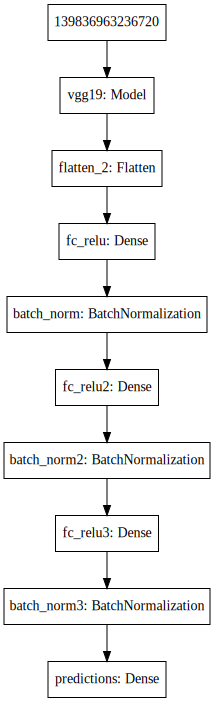

In [0]:
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Here will use ImageNet weights that was tested before and add our layers to the neural network
vgg=VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3))

# Freezing the weights and biases of these layers and keeping the information that was already
# learned  through VGG original
for layer in vgg.layers:
    layer.trainable = False

model=Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(4096,activation='relu',name='fc_relu'))
model.add(BatchNormalization(name='batch_norm'))
model.add(Dense(1000,activation='relu',name='fc_relu2'))
model.add(BatchNormalization(name='batch_norm2'))
model.add(Dense(512,activation='relu',name='fc_relu3'))
model.add(BatchNormalization(name='batch_norm3'))
model.add(Dense(5,activation='softmax',name='predictions'))

SVG(model_to_dot(model).create(prog='dot',format='svg'))

I've tried to use Dropout instead of Batch Normalization but it gave me 5% validation accuracy so i went back to Batch Normalization.
<hr>
<h2> Splitting the data and Over-Sampling</h2>
In this section we will split the data and use a SMOTE over-sampling, for those who don't know what is the SMOTE technique to treat imbalanced data you can access [righ here](https://medium.com/towards-artificial-intelligence/application-of-synthetic-minority-over-sampling-technique-smote-for-imbalanced-data-sets-509ab55cfdaf) to check out.
<br>
<br>

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Shuffling our dataset to get more generalized data
X,y=shuffle(img_matrix,df['level'],random_state=56)

# Splitting
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=.2)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,test_size=.15)

# Transformin the data to array
X_train=np.array(X_train)
X_test=np.array(X_test)
X_val=np.array(X_val)

print('X_train shape before SMOTE: {}'.format(X_train.shape))
print('y_train shape before SMOTE: {}'.format(y_train.shape))

# SMOTE Over-Sampling
from imblearn.over_sampling import SMOTE
smote=SMOTE(ratio='minority',random_state=42)

# Reshaping the train features so we can use SMOTE to over-sampling it
X_train=X_train.reshape(X_train.shape[0],-1)

# Note: ravel() just turn our matrix to a array with the same order
X_train_sm,y_train_sm=smote.fit_sample(X_train,y_train.ravel())

# Reshaping it to 256x256x3
X_train_sm=X_train_sm.reshape(X_train_sm.shape[0],256,256,3)

print('X_train shape after SMOTE: {}'.format(X_train_sm.shape))
print('y_train shape after SMOTE: {}'.format(y_train_sm.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

# Turning the dtype to float so we can divide by 255(pixel range)
X_train_sm=X_train_sm.astype('float32')
X_test=X_test.astype('float32')
X_val=X_val.astype('float32')

X_train_sm/=255
X_val/=255
X_test/=255

X_train shape before SMOTE: (680, 256, 256, 3)
y_train shape before SMOTE: (680,)
X_train shape after SMOTE: (1160, 256, 256, 3)
y_train shape after SMOTE: (1160,)
X_val shape: (120, 256, 256, 3)
y_val shape: (120,)
X_test shape: (200, 256, 256, 3)
y_test shape: (200,)


Right, now that we already dealed with our imbalanced data we can turn our into a binary classification. With DR and No DR.

In [0]:
from keras.utils import np_utils

y_train=np_utils.to_categorical(y_train_sm,5)
y_test=np_utils.to_categorical(y_test,5)
y_val=np_utils.to_categorical(y_val,5)

## Choosing our Optimizer and metrics
If you don't have any idea of gradient descent i highly recommend to watch [this video](https://www.youtube.com/watch?v=nhqo0u1a6fw) which will give you a quick view of certain gradient descents that was implemented through the years.
<br>
<br>
In our case i'll be testing with adam, nadam, sgd and rmsprop to check which have the best perfomance.
<br>
<br>
Note: nadam, rmsprop and sgd got me train accuracy really high like 95% but was overfitted, so adam got me a better validation accuracy.

<hr>
## Compiling and training
Now that we have all set it up, let's train and see our perfomance in this data.

In [0]:
from keras.optimizers import Adam
# 200=epochs
opt=Adam(1e-3,decay=1e-3/200)

batchsize=10

model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
fc_relu (Dense)              (None, 4096)              134221824 
_________________________________________________________________
batch_norm (BatchNormalizati (None, 4096)              16384     
_________________________________________________________________
fc_relu2 (Dense)             (None, 1000)              4097000   
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 1000)              4000      
_________________________________________________________________
fc_relu3 (Dense)             (None, 512)               512512    
__________

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# EarlyStopping will monitorate our val_loss and wait before early stop if 
# no progress on the validation set.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

aug=ImageDataGenerator()
history=model.fit_generator(aug.flow(X_train_sm,y_train,batch_size=batchsize),epochs=200,
                  steps_per_epoch=int(len(X_train_sm)/batchsize),
                  validation_data=aug.flow(X_val,y_val,batch_size=batchsize),
                            validation_steps=int(len(X_val)/batchsize),
                            verbose=2,shuffle=True,callbacks=[es])

Epoch 1/200
 - 20s - loss: 0.8099 - acc: 0.7905 - val_loss: 0.5934 - val_acc: 0.8250
Epoch 2/200
 - 12s - loss: 0.5255 - acc: 0.8405 - val_loss: 1.5349 - val_acc: 0.4750
Epoch 3/200
 - 12s - loss: 0.4583 - acc: 0.8638 - val_loss: 0.8974 - val_acc: 0.7583
Epoch 4/200
 - 12s - loss: 0.3780 - acc: 0.8784 - val_loss: 0.7155 - val_acc: 0.8000
Epoch 5/200
 - 12s - loss: 0.3570 - acc: 0.8828 - val_loss: 0.6748 - val_acc: 0.8167
Epoch 6/200
 - 12s - loss: 0.3391 - acc: 0.8897 - val_loss: 0.8572 - val_acc: 0.6667
Epoch 7/200
 - 12s - loss: 0.3371 - acc: 0.8931 - val_loss: 0.9225 - val_acc: 0.7000
Epoch 8/200
 - 12s - loss: 0.2529 - acc: 0.9069 - val_loss: 0.6932 - val_acc: 0.8417
Epoch 9/200
 - 12s - loss: 0.2598 - acc: 0.9095 - val_loss: 0.7656 - val_acc: 0.7833
Epoch 10/200
 - 12s - loss: 0.2660 - acc: 0.9216 - val_loss: 0.9790 - val_acc: 0.7833
Epoch 11/200
 - 12s - loss: 0.2300 - acc: 0.9190 - val_loss: 1.4144 - val_acc: 0.7917
Epoch 12/200
 - 12s - loss: 0.1607 - acc: 0.9457 - val_loss: 1.

## Evaluation
ROC Curves use AUC(Area Under Curve) to evaluate our model checking the correlation of TPR(True Positive Rate) and FPR(False Positive Rate), since we already balanced our data we can use ROC Curves to evaluate our model.
<br>
<br>
Since i couldn't do by myself a multi-class ROC Curves, i found out someone who implemented it.<br>
[ROC-Keras](https://github.com/Tony607/ROC-Keras/blob/master/ROC-Keras.ipynb)<br><br>
Thanks to Chengwei Zhang who saved my life in that project haha.

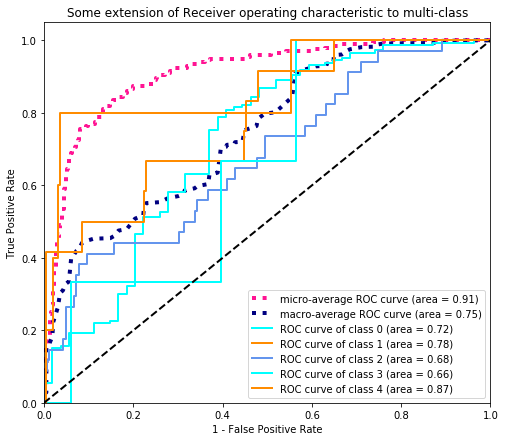

In [0]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

y_score=model.predict(X_test)
n_classes=5
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Looks like we got a good micro-average ROC AUC score but unfortunately not that good for classes and macro-average.<br><br>
Now let's check the accuracy and loss of our model, hopefully we made out a good model.

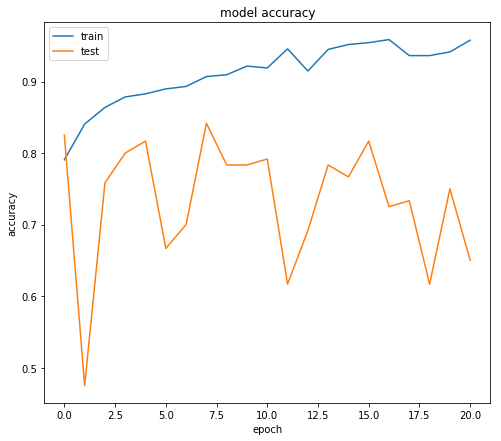

In [0]:
plt.figure(figsize=(8,7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

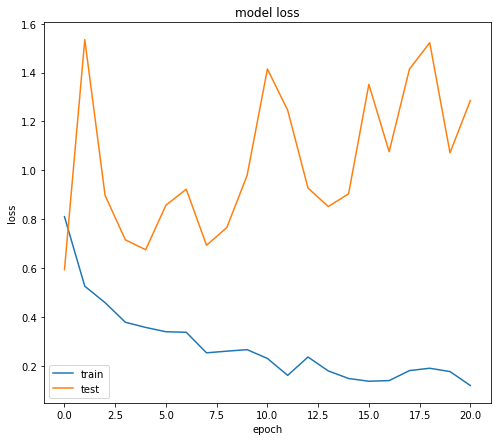

In [0]:
plt.figure(figsize=(8,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Our model is basically overfitting it, i tried to prevent it changing the learning rate, using earlystopping to interrupt training if the validation loss function was stable, shuffling the data, etc.<br><br>
Anyway, if someone know how to prevent it in this dataset, contact me, i'll honor to know your opinion and how we can improve it to get better results.<br>
<br>
Now let's check the results with a confusion matrix, so we can how our model is focusing to predict.

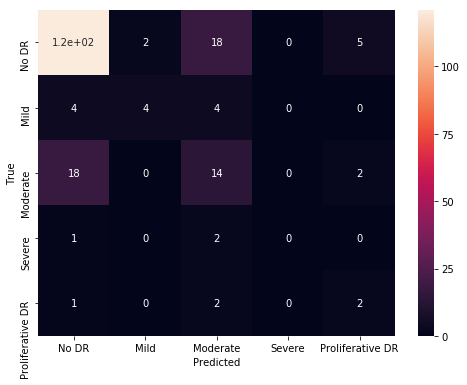

In [0]:
from sklearn.metrics import confusion_matrix

labels=['No DR','Mild','Moderate','Severe','Proliferative DR']
cm=confusion_matrix(np.argmax(y_test,-1),np.argmax(y_score,-1))
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As we can see, our model is focusing to predict people with No DR, since it's really important to have both of two worlds(sensitivity and specificity) our model got 2 of 5 cases of Proliferative DR right and 0 of 3 of Severe cases.<br><br>
Our model focused so much to learn how to define a No DR~Moderate cases that when shows up a Severe~Proliferative DR he doesn't know how to predict it, basically we need a more generalized data to get better results.

In [0]:
from sklearn.metrics import accuracy_score, classification_report

print('Accuracy on Test Data: {}'.format(accuracy_score(np.argmax(y_test,-1),np.argmax(y_score,-1))))
print(classification_report(np.argmax(y_test,-1),np.argmax(y_score,-1)))

Accuracy on Test Data: 0.705
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       146
           1       0.67      0.33      0.44        12
           2       0.35      0.41      0.38        34
           3       0.00      0.00      0.00         3
           4       0.22      0.40      0.29         5

    accuracy                           0.70       200
   macro avg       0.41      0.39      0.39       200
weighted avg       0.71      0.70      0.71       200



## Conclusion
<br>
Our model performed better than i expected, tbh i though that the accuracy and others metrics would be really low.
<br>
That was my first project involving deep learning and neural networks, i think i can say it was a project because i done a lot of research to find diversity of architectures, optimizers, loss functions, etc.
<br>
<br>
Considering that these projects i do are to fix what i learn in Data Science, i also end up contributing to the community and being able to bring some of the experience i had doing the project.
<br>
<hr>
<br>
If you saw something wrong or want to improve what i've done, feel free to contact me so we can make it better together.
<br>
<br>
Last note: My english still very rusty so i'm sorry if it was hard to understand some things.